# Jupyter Notebook for IFAT VCO implementation

This notebook lays out step-by-step the VCO matrix implementation (proposed by [Welday _et al._, 2011](http://www.jneurosci.org/content/31/45/16157.long)) to be implemented on the IFAT system.


First, we'll import the necessary Python packages:

In [1]:
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
import math

import vco  # this is the Python library developed for this project - for clarity, 
            # I'll use it in this notebook only after I've already 
            # explained/developed the functions or for plotting

%matplotlib inline

### VCO model as a Python class
First, we create a Python class to model the VCO; this is a purely mathematical representation of the VCO. By this, we mean that the VCO is described by variables and parameters that allow us to calculate the activity for a given spatial path, rather than the VCO being an actual unit oscillating in time. In other words, it is represented by a series of shifted sinusoids, instead of a variable-frequency oscillator.

The first three functions in the class are used internally to initialize and print an instance of the VCO model. Each VCO has the following parameters that describe it:
* $N$ - the number of cells in the VCO
* $\rho$ - the slope of speed modulation (relating to the preferred vector magnitude)
* $\theta$ - the preferred vector orientation
* `phz_noise` - a variable controlling the amount of jitter added to the preferred directions of the VCO's cells (we will leave this at 0, meaning that the preferred directions are each $\frac{2\pi}{N}$ greater than the previous cell.

The last function, `cell_activity`, allows us to see the activity of the VCO at a given location, for a given cell within the VCO.

In [2]:
class VCO_model:

    def __init__(self, N, rho, theta, phz_noise=0):
        self.N = N                       # number of cells in VCO
        self.rho = rho                   # slope of speed modulation
        self.theta = theta               # preferred orientation
        self.phz_noise = phz_noise       # amount of noise introduced in phase offset between each of N cells
        self.cellphz = self._set_noise() # length N array of phase offsets for each cell 

    def __repr__(self):
        rs = 'VCO [N={}, (rho, theta)=({}, {:f}), phi_n={}]'
        return rs.format(self.N, self.rho, self.theta, self.phz_noise)

    def _set_noise(self):
        '''
        Sets jitter between VCO cell preferred directions using
        uniform noise.
                      
        Returns
        -------
        cellphz: ndarray (N,) dtype=float
            Array of phase offsets for each cell in the VCO.
        '''
        cellphz = np.zeros(self.N)
        phz_int = 2.0 * np.pi / self.N
        valid = False
        while not valid:
            phase = 0
            for i in range(self.N):
                cellphz[i] = phase
                if (i==(self.N-1)):
                    if not((phase > 2*np.pi) or (phase < 2*(np.pi - phz_int))):
                        valid = True
                else:
                    noise = (2 * phz_int * (nprd.random()-0.5)) * self.phz_noise
                    phase = phase + phz_int + noise
        return cellphz
    
    def get_angular_freq(self, cell, pol_vel, base_freq=8.0):
        '''
        Returns instantaneous angular frequency omega for specified cell in VCO.
        Implements Welday et al. (2011) equation 11.
        
        Parameters
        ----------
        cell : int
            Index of VCO cell.
            
        pol_vel : ndarray (_, 2) dtype=float
            Allocentric polar velocity vector
        
        base_freq : float
            Shared angular base frequency of all VCOs.
        
        Returns
        -------
        omega : ndarray (len(pol_vel),) dtype=float
            VCO instantaneous angular frequency at all time steps specified by
            pol_vel.
        '''
        vel_term = (self.rho * pol_vel[:,0])/(2 * np.pi)
        phz_term = np.cos(pol_vel[:,1] + self.cellphz[cell] - self.theta)
        omega = base_freq + vel_term * phz_term
        return omega

    
    def get_envelope(self, cell, x, y):
        '''
        Returns spatial envelope function, analogous to firing map.
        Implements Welday et al. (2011) equation 20.
        
        Parameters
        ----------
        cell : int
            Index of VCO cell.
            
        x : ndarray * dtype=float
            Array of location x values.
                
        y : ndarray * dtype=float
            Array of location y values.
              
        Returns
        -------
        E : ndarray * dtype=float
            Envelope function determining spatially-tuned VCO activity.
            
        Notes
        _____
        * Shape of x, y, and E arrays can be either 1-D (illustrating an
        actual path through space) or multi-dimensional (e.g. np.meshgrid())
        '''
        x_term = self.rho * np.cos(-self.theta) * x
        y_term = self.rho * np.sin(-self.theta) * y
        phz_term = self.cellphz[cell] + np.pi/2.0
        return np.exp(1j * (x_term + y_term + phz_term));

The function `get_envelope(cell, x, y)` returns the envelope (analogous to firing rate) of the cell at index `cell` $[0,N)$ in the VCO for the path defined by the arrays $x$ and $y$. This is the building block for all the simulations and visualizations in my code.

The math for this is somewhat complicated; it starts with by defining the instantaneous angular frequency of the VCO (the speed with which a spike travels around the VCO, so effectively the spiking frequency of all N VCO neurons) as:

$$ \omega_n(t) = \Omega(t) + \mathbf{d}_n \cdot \mathbf{v}(t)$$

where $\Omega(t)$ is the "shared angular base frequency" (the theta frequency of ~8Hz), $\mathbf{d}_n$ is the preferred direction vector for VCO $n$, and $\mathbf{v}(t)$ is the velocity vector of the animal (equation 11 in the text). The dot product $\mathbf{d}_n \cdot \mathbf{v}(t)$ is what Ralph was referring to in our meeting. This is the equation implemented by the function `get_angular_freq(cell, pol_vel, base_freq)`. **_Effectively, the frequency of a VCO is modulated around a base frequency by the dot product of the velocity and the preferrred direction._ I think that this is the most relevant equation for implementation.**


To get from this equation to the equation in `get_envelope()`, we first integrate the equation above to find the instantaneous _phase_ of the VCO:

$$ \phi_n(t) = \Phi(t) + \delta_n(\mathbf{x}(t))$$

where $\Phi(t)$ is, similarly, the shared base phase (from integrating $\Omega$ over the interval $[0,t)$), and $\delta_n$ is the phase offset of a particular VCO - this depends on the animal's location, $\mathbf{x}(t)$. With this, we can bring back in the animal's position (which makes sense, since we've integrated velocity):

$$
\begin{eqnarray}
\delta_n(\mathbf{x}(t)) &=& \phi_n(0) - \Omega(0) + \mathbf{d}_n \cdot \left[ \mathbf{x}(t) - \mathbf{x}(0) \right] \\
\phi_n(t) &=& \Phi(t) + \bigg( \big(\phi_n(0) - \Omega(0)\big) + \mathbf{d}_n \cdot \big[\mathbf{x}(t) - \mathbf{x}(0)\big]\bigg)
\end{eqnarray}
$$


Taking $N$ VCOs and summing them with some weight pattern gives us an interference pattern:

$$
\begin{eqnarray}
I(t) = \sum^{N}_{n=1} w_n \cos{\phi_n(t)} = C(t)E(\mathbf{x})
\end{eqnarray}
$$
where $w_n$ is the weight for the $n$th VCO. This gives us a time-varying carrier signal $C(t)$ and a spatially varying envelope signal $E(\mathbf{x})$. Via "a trick based on Euler's formula 1", we get to this formula:

$$ E(\mathbf{x}) = \biggl| \sum_{n=1}^N w_n \exp{(i \delta_n(\mathbf{x}))} \biggr|$$

In this code, we're really finding the envelopes to plot (rather than the true firing rate, which is analogous to the time-signal $I(t)$. So, for an individual VCO, what we're interested in is that value $\exp{(i \delta_n(\mathbf{x}))}$. 

Our next step is to put $\mathbf{d}_n$ in polar coordinates, such that $$\mathbf{d}_n = [\rho, \theta]$$ Using the equation for $\delta_n(\mathbf{x}(t))$ above:

$$
\begin{eqnarray}
\delta_n(\mathbf{x}) &=& \mathbf{d}_n \cdot \mathbf{x} + \phi_n(0) - \Omega(0) + \mathbf{d}_n \cdot  \mathbf{x}(0) \\
&=& [\rho,\theta] \cdot [x,y] + \xi_{m,n} \\
&=& x \rho  \cos{(\theta)} + y \rho \sin{(-\theta)} + \xi_{m,n}
\end{eqnarray}
$$

where $\xi_{m,n}$ is the phase offset of the $m$th cell in the $n$th VCO. This finally brings us to the equation defining `cell_activity(cell, x, y)`:

$$
E(\mathbf{x}) = \exp{\biggl( i \bigl( x \rho \cos{(\theta)} + y \rho \sin{(-\theta)} + \xi_{m,n}\bigr) \biggr)}
$$

### Demonstrating the VCO model

The math is done for the moment, so we'll move on to demonstrate the VCO model. We'll start with a single VCO, showing its activity as we change the direction of the velocity vector while keeping its magnitude the same. We'll plot the tuning curve, showing the change in instantaneous angular frequency of the cell as we vary direction.

In [3]:
# Instantiate a VCO model
rho = 0.14
theta = np.pi+0.5
N = 12
VCO = VCO_model(N, rho, theta)

In [4]:
# Create a simulated running path (constant velocity, running around in a circle)
d = np.arange(0, 2 * np.pi, 0.001)
v = 2*np.ones_like(d)
pol_path = np.asarray([v,d]).T
x = v * np.cos(d)
y = v * np.sin(d)

In [5]:
# Create tuning curves by calculating angular frequency
tune = np.zeros((d.shape[0],N))
for cell in range(N):
    tune[:,cell] = VCO.get_angular_freq(cell, pol_path)

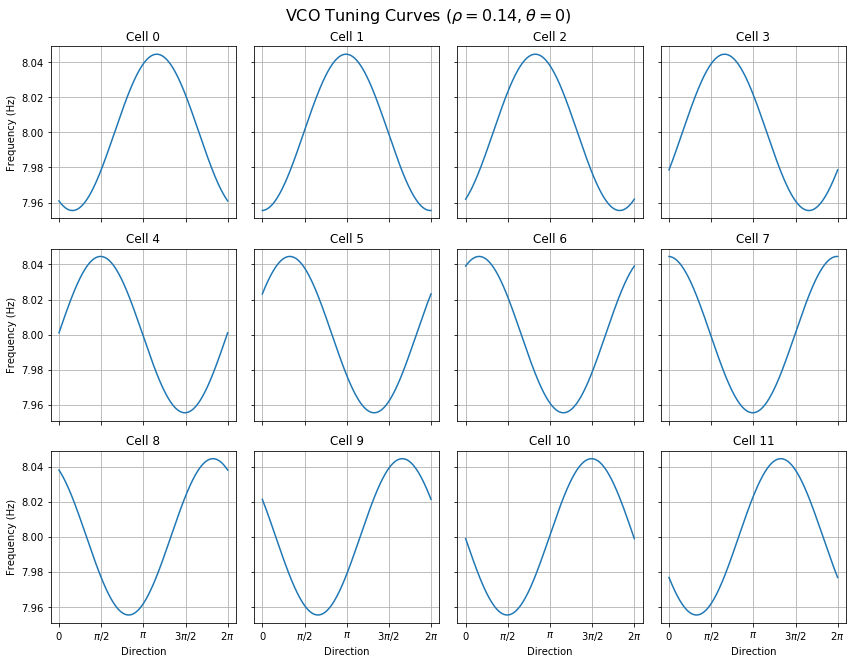

In [6]:
# Plot the tuning curves
fig, axs = plt.subplots(3,4,sharex=True,sharey=True,figsize=(12,9))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for cell in range(N):
    axs[cell].plot(d,tune[:,cell])
    axs[cell].set_title('Cell %d' % cell)
    axs[cell].grid()
    
    if not (cell) % 4:
        axs[cell].set_ylabel('Frequency (Hz)')
    if cell >= 8:
        axs[cell].set_xlabel('Direction')
        axs[cell].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
        axs[cell].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"]);

plt.tight_layout()
plt.suptitle(r"VCO Tuning Curves ($\rho = 0.14, \theta = 0$)",fontsize=16,y=1.02);

This is what we'd like to see from a single VCO; basically, proof that the dot product between preferred direction and velocity is being calculated correctly - the VCO fires maximally at its preferred direction and minimally at its antipreferred direction.

### Combining VCOs in the VCO matrix
Next we'll create Grid Cells, Place Cells, and Border Cells, following the VCO matrix connectivity described in the Welday paper. 

In [7]:
# Create the 6-by-12 VCO matrix
rhos = 0.14 * (np.sqrt(3) ** np.arange(6))
thetas = np.pi + 2.0*np.pi*(np.arange(N))/N

numrow = 6; numcol = 12;

VCOmatrix = [[VCO_model(N, rhos[i], thetas[j]) for j in range(numcol)] for i in range(numrow)]

In [8]:
# Helper function to plot connection weights
def plot_weights(weights):
    # Plot weights matrix
    (y_size, x_size) = weights.shape
    plt.figure()#figsize=(10,10))
    im = plt.imshow(weights,cmap='jet',origin='lower')
    ax = plt.gca()
    plt.title('Weights Matrix')
    ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5,x_size,1))
    ax.set_yticks(np.arange(-0.5,y_size,1))
    ax.set_xticklabels(np.arange(0, 12, 1))
    ax.set_yticklabels(np.arange(0, 6, 1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    plt.colorbar(im, cax=cax)

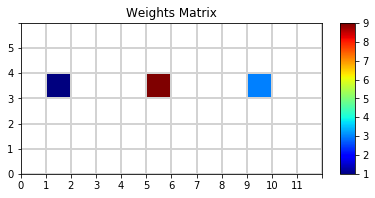

In [9]:
# Create array of weights for the matrix to make a grid cell
weights_grid = np.full([numrow, numcol], np.nan)
weights_grid[3,1] = 1; weights_grid[3,5] = 9; weights_grid[3,9] = 3
plot_weights(weights_grid)

In [10]:
# Helper function for matrix that sums activity of cells indicated in weights matrix (weights = 1)
def matrix_sum(matrix, weights, size):
    # Create mesh grid to tile space of [[-size, size],[-size, size]]
    ss = np.linspace(-size,size,10*size)
    xx, yy = np.meshgrid(ss,ss)
    
    # Find sum of responses from all cells identified in weights matrix
    response_sum = np.zeros([10*size,10*size],dtype='complex128')
    for row in range(weights.shape[0]):
        for col in range(weights.shape[1]):
            if not np.isnan(weights[row,col]):
                cell_response = matrix[row][col].get_envelope(int(weights[row,col]), xx, yy)
                response_sum = response_sum + cell_response

    # Normalize and threshold at 65% of the maximum response
    response_sum = abs(response_sum)
    max_response = np.max(response_sum)
    thresh = response_sum - 0.65*max_response
    thresh[thresh<0] = 0
    max_response = np.max(thresh)
    response_norm = thresh / max_response
    return response_norm, response_sum


In [11]:
arena_size = 5;
grid_norm, grid_sum = matrix_sum(VCOmatrix, weights_grid, arena_size)

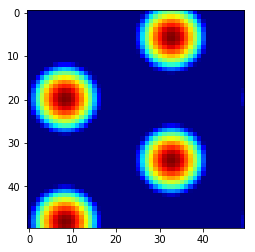

In [12]:
plt.imshow(grid_norm,cmap='jet')

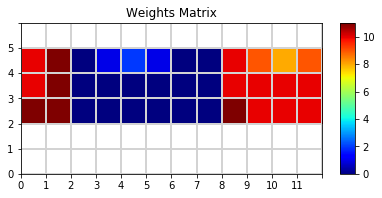

In [13]:
# Create array of weights for the matrix to make a place cell
weights_place_1 = np.full([numrow, numcol], np.nan)
weights_place_1[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
weights_place_1[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
weights_place_1[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]
plot_weights(weights_place_1)

In [14]:
place_1_norm, place_1_sum = matrix_sum(VCOmatrix, weights_place_1, arena_size)

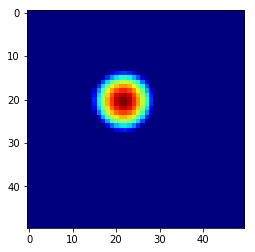

In [15]:
plt.imshow(place_1_norm, cmap='jet')

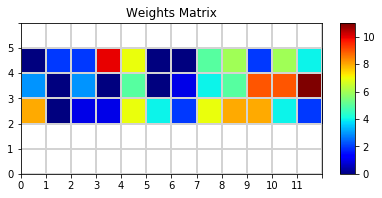

In [16]:
# And now, a multi-field place cell
weights_place_2 = np.full([numrow, numcol], np.nan)
weights_place_2[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
weights_place_2[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
weights_place_2[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]
plot_weights(weights_place_2)

In [17]:
place_2_norm, place_2_sum = matrix_sum(VCOmatrix, weights_place_2, arena_size)

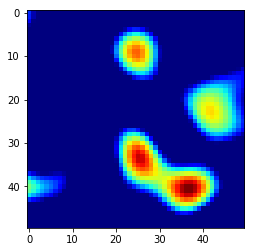

In [18]:
plt.imshow(place_2_norm, cmap='jet')

## Additional Place Cell Strategies (extra credit)
These are further reach goals for the paper - demonstrating creating places cells _from_ grid cells, either randomly or with a biologically-grounded connectivity pattern.

In [19]:
# Create fully connected grid cell matrix for rows 2-4
partial_matrix = np.full([6,12,2*4*12**3], np.nan)
jdx = 0
for row in range(2,4):
    for firstcol in range(4):
        for cell1 in range(12):
            for cell2 in range(12):
                for cell3 in range(12):
                    partial_matrix[row,firstcol,  jdx] = cell1
                    partial_matrix[row,firstcol+4,jdx] = cell2
                    partial_matrix[row,firstcol+8,jdx] = cell3
                    jdx = jdx + 1

grid_weights = partial_matrix

In [20]:
# Find all 13824 grid cell envelopes
size = 5
num_grids = grid_weights.shape[2]

grid_outputs = np.zeros([10*size, 10*size, num_grids])
for gc in range(num_grids):
    grid_outputs[:,:,gc], _ = matrix_sum(VCOmatrix,grid_weights[:,:,gc],size)

Next, we'll define a probability distribution function to determine synaptic weight based on experimentally observed synapse sizes; this function is adapted from the math described in this [2009 paper by de Almeida](http://www.jneurosci.org/content/29/23/7504.long).

In [21]:
def almeida_weights(size):
    A, B = 100.7, 0.02
    sigma = np.array([0.02, 0.018, 0.15])
    s = np.arange(0,0.2,0.0001)
    dist = A * (1 - np.exp(- s/sigma[0])) * (np.exp(- s/sigma[1]) + B * np.exp(- s/sigma[2]))
    pdf = dist/np.sum(dist)
    syn_diam = nprd.choice(s,size=size,p=pdf)
    weights = (syn_diam/0.2)*(syn_diam/(syn_diam+0.0314))
    return weights

Now, we'll make 50 place cells, each taking 1500 randomly chosen grid cell inputs, with weights determined either randomly or by the PDF above (same weights each time, but grid cells chosen differently).

In [22]:
num_places = 50
num_gc = 1500

place_cells = np.zeros([10*size, 10*size, num_places, 3])
weights = almeida_weights(num_gc)
rand_weights = nprd.random_sample(weights.shape)

for pc in range(num_places):
    idx = np.arange(num_grids)
    nprd.shuffle(idx)
    idx = idx[0:num_gc]
    for i, gc_ind in enumerate(idx):
        place_cells[:,:,pc,0] = place_cells[:,:,pc,0] + weights[i] * grid_outputs[:,:,gc_ind]
        place_cells[:,:,pc,2] = place_cells[:,:,pc,2] + rand_weights[i] * grid_outputs[:,:,gc_ind]

Plot the weights!

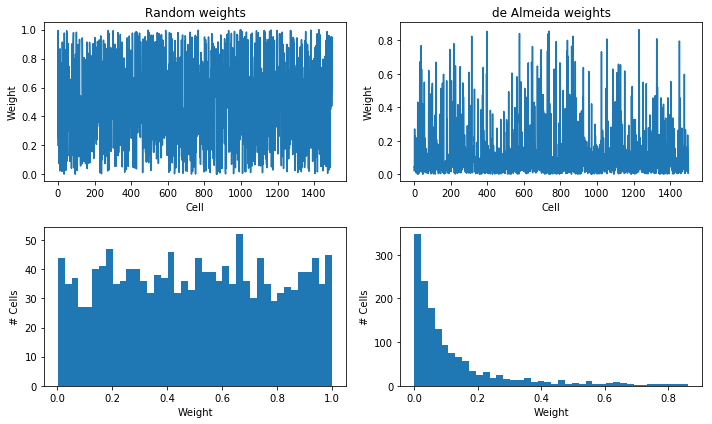

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(221); plt.plot(rand_weights); plt.xlabel('Cell'); plt.ylabel('Weight'); plt.title('Random weights')
plt.subplot(222); plt.plot(weights); plt.xlabel('Cell'); plt.ylabel('Weight'); plt.title('de Almeida weights')
plt.subplot(223); plt.hist(rand_weights,bins=40); plt.xlabel('Weight'); plt.ylabel('# Cells');
plt.subplot(224); plt.hist(weights, bins=40); plt.xlabel('Weight'); plt.ylabel('# Cells');
plt.tight_layout()

Normalize by the E%-max concept, described in the same paper - this is fluff with regards to our paper, but I've included it here for completeness.

In [24]:
k_thresh = 0.1
reset_val = np.amin(place_cells[:,:,:,0])
for pc in range(num_places):
    for x in range(place_cells.shape[0]):
        for y in range(place_cells.shape[1]):
            if place_cells[x,y,pc,0] >= (1-k_thresh)*np.max(place_cells[x,y,:,0]):
                place_cells[x,y,pc,1] = place_cells[x,y,pc,0]
            else:
                place_cells[x,y,pc,1] = reset_val

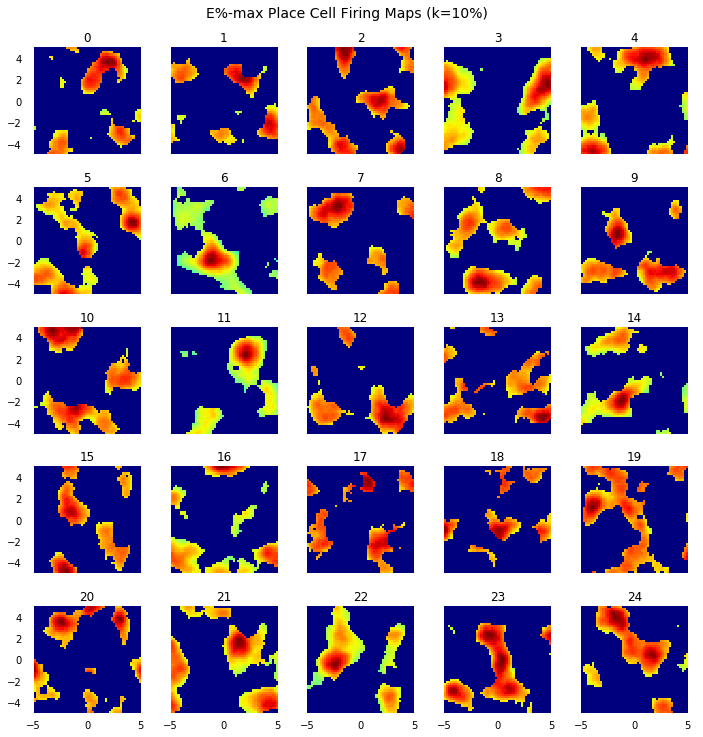

In [25]:
vco.plot_many(place_cells[:,:,:25,1],size)
plt.suptitle('E%-max Place Cell Firing Maps (k=10%)',fontsize=14,y=1.02)

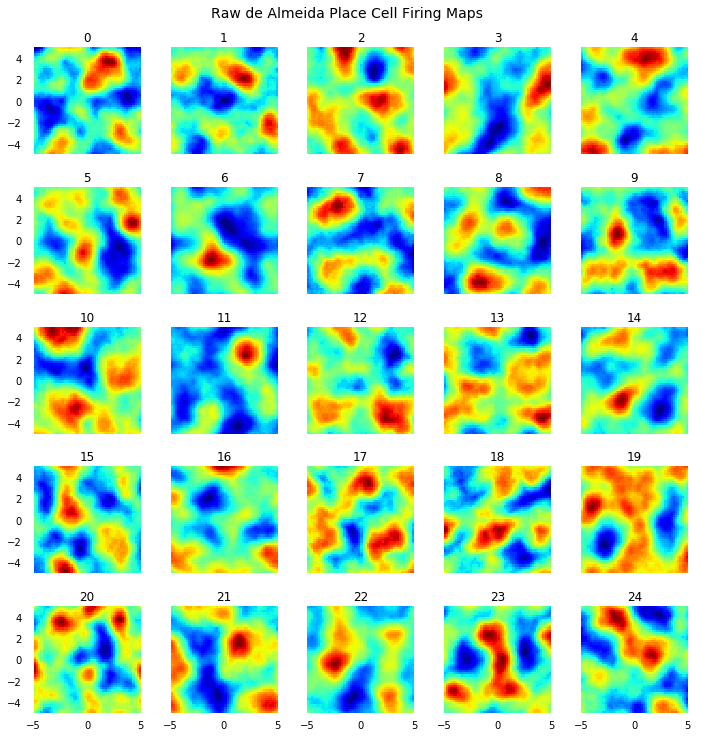

In [26]:
vco.plot_many(place_cells[:,:,:25,0],size)
plt.suptitle('Raw de Almeida Place Cell Firing Maps',fontsize=14,y=1.02)

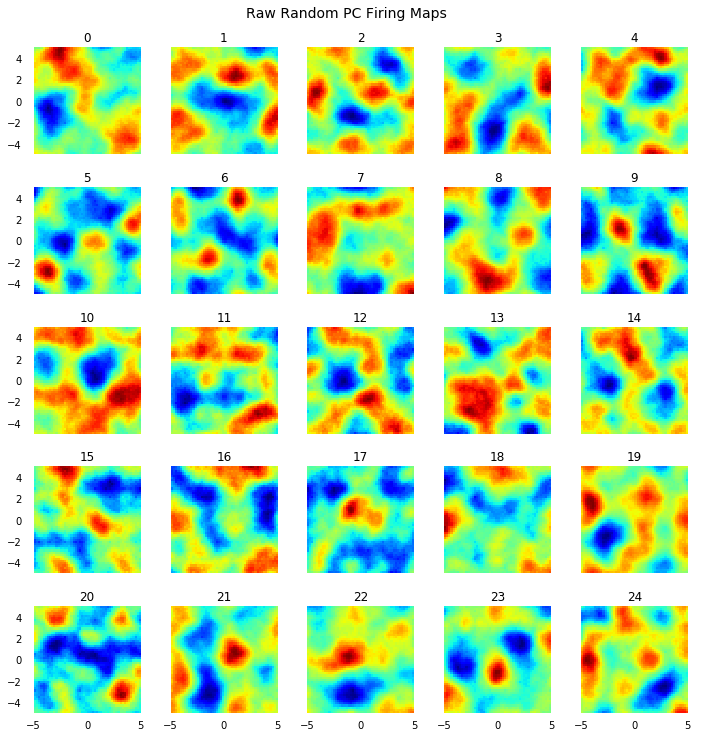

In [27]:
vco.plot_many(place_cells[:,:,:25,2],size)
plt.suptitle('Raw Random PC Firing Maps',fontsize=14,y=1.02)